# Second Order Approximation for N $\to\infty$

## Set Up

### Importing Packages

In [2]:
import numpy as np

import sympy as sym
from sympy.physics.paulialgebra import Pauli, evaluate_pauli_product
from sympy import I

import scipy as sc
import scipy.constants as scc
from scipy.integrate import solve_ivp

import matplotlib
import matplotlib.pyplot as plt

import csv
import json

from datetime import datetime
import os

from copy import *
import pickle

from qutip import *

from collections.abc import Iterable

### Plotting Function

### Defining the Symbols

In [3]:
w0, k, S = sym.symbols('omega_0 kappa S', real=True)
Sx, Sy, Sz, Sp, Sm = sym.symbols('S_x S_y S_z S_p S_m', commutative=False)

Sp = Sx + sym.I*Sy
Sm = Sx - sym.I*Sy

In [36]:
m_x, m_y, m_z = sym.symbols('m_x, m_y, m_z', real = True)

n_xx, n_xy, n_xz, n_yx, n_yy, n_yz, n_zx, n_zy, n_zz = sym.symbols('n_xx n_xy n_xz n_yx n_yy n_yz n_zx n_zy n_zz', real = True)

l_xxx, l_xxy, l_xxz, l_xyx, l_xyy, l_xyz, l_xzx, l_xzy, l_xzz = sym.symbols('l_xxx l_xxy l_xxz l_xyx l_xyy l_xyz l_xzx l_xzy l_xzz', real = True)
l_yxx, l_yxy, l_yxz, l_yyx, l_yyy, l_yyz, l_yzx, l_yzy, l_yzz = sym.symbols('l_yxx l_yxy l_yxz l_yyx l_yyy l_yyz l_yzx l_yzy l_yzz', real = True)
l_zxx, l_zxy, l_zxz, l_zyx, l_zyy, l_zyz, l_zzx, l_zzy, l_zzz = sym.symbols('l_zxx l_zxy l_zxz l_zyx l_zyy l_zyz l_zzx l_zzy l_zzz', real = True)

ch_xx, ch_xy, ch_xz, ch_yy, ch_yz, ch_zz = sym.symbols('chi_xx chi_xy chi_xz chi_yy chi_yz chi_zz')
zeta_xx, zeta_xy, zeta_xz, zeta_yy, zeta_yz, zeta_zz = sym.symbols('zeta_xx zeta_xy zeta_xz zeta_yy zeta_yz zeta_zz')

### Defining the Commutators

In [5]:
def comm(A,B):
    if not isinstance(A, Iterable) and not isinstance(B, Iterable):
        if A == B:
            return 0
        elif A == Sx and B == Sy:
            return I*Sz
        elif A == Sx and B == Sz:
            return -I*Sy
        elif A == Sy and B == Sx:
            return -I*Sz
        elif A == Sy and B == Sz:
            return I*Sx
        elif A == Sz and B == Sx:
            return I*Sy
        elif A == Sz and B == Sy:
            return -I*Sx
        elif A == Sp and B == Sm:
            return 2*Sz
        elif A == Sm and B == Sp:
            return -2*Sz
        elif A == Sp:
            return comm(Sx,B)+I*comm(Sy,B)
        elif A == Sm:
            return comm(Sx,B)-I*comm(Sy,B)
        elif B == Sp:
            return comm(A,Sx)+I*comm(A,Sy)
        elif B == Sm:
            return comm(A,Sx)-I*comm(A,Sy)
        else:
            print('Error')
            return A*B - B*A
    elif isinstance(A, Iterable) and not isinstance(B, Iterable):
        if B == Sp:
            return A[0]*comm(A[1],Sx) + I*A[0]*comm(A[1],Sy) + comm(A[0],Sx)*A[1] + I*comm(A[0],Sy)*A[1]
        elif B == Sm:
            return A[0]*comm(A[1],Sx) - I*A[0]*comm(A[1],Sy) + comm(A[0],Sx)*A[1] - I*comm(A[0],Sy)*A[1]
        else:
            return A[0]*comm(A[1],B) + comm(A[0],B)*A[1]
    elif not isinstance(A, Iterable) and isinstance(B, Iterable):
        if A == Sp:
            return B[0]*comm(Sx,B[1]) + I*B[0]*comm(Sy,B[1]) + comm(Sx,B[0])*B[1] + I*comm(Sy,B[0])*B[1]
        elif A == Sm:
            return B[0]*comm(Sx,B[1]) - I*B[0]*comm(Sy,B[1]) + comm(Sx,B[0])*B[1] - I*comm(Sy,B[0])*B[1]
        else:
            return B[0]*comm(A,B[1]) + comm(A,B[0])*B[1]
    else:
        print('Error')
        return 0

### Simplification Substitutions

In [6]:
subs_list = {Sx/S: m_x,
             Sy/S: m_y,
             Sz/S: m_z,
             Sx*Sx/(S**2): n_xx,
             Sx*Sy/(S**2): n_xy,
             Sx*Sz/(S**2): n_xz,
             Sy*Sx/(S**2): n_yx,
             Sy*Sy/(S**2): n_yy,
             Sy*Sz/(S**2): n_yz,
             Sz*Sx/(S**2): n_zx,
             Sz*Sy/(S**2): n_zy,
             Sz*Sz/(S**2): n_zz,
             Sx*Sx*Sx/(S**3): l_xxx,
             Sx*Sx*Sy/(S**3): l_xxy,
             Sx*Sx*Sz/(S**3): l_xxz,
             Sx*Sy*Sx/(S**3): l_xyx,
             Sx*Sy*Sy/(S**3): l_xyy,
             Sx*Sy*Sz/(S**3): l_xyz,
             Sx*Sz*Sx/(S**3): l_xzx,
             Sx*Sz*Sy/(S**3): l_xzy,
             Sx*Sz*Sz/(S**3): l_xzz,
             Sy*Sx*Sx/(S**3): l_yxx,
             Sy*Sx*Sy/(S**3): l_yxy,
             Sy*Sx*Sz/(S**3): l_yxz,
             Sy*Sy*Sx/(S**3): l_yyx,
             Sy*Sy*Sy/(S**3): l_yyy,
             Sy*Sy*Sz/(S**3): l_yyz,
             Sy*Sz*Sx/(S**3): l_yzx,
             Sy*Sz*Sy/(S**3): l_yzy,
             Sy*Sz*Sz/(S**3): l_yzz,
             Sz*Sx*Sx/(S**3): l_zxx,
             Sz*Sx*Sy/(S**3): l_zxy,
             Sz*Sx*Sz/(S**3): l_zxz,
             Sz*Sy*Sx/(S**3): l_zyx,
             Sz*Sy*Sy/(S**3): l_zyy,
             Sz*Sy*Sz/(S**3): l_zyz,
             Sz*Sz*Sx/(S**3): l_zzx,
             Sz*Sz*Sy/(S**3): l_zzy,
             Sz*Sz*Sz/(S**3): l_zzz
}

In [7]:
l_subs_list={
    l_xxx: m_x*n_xx + m_x*n_xx + m_x*n_xx - 2*m_x*m_x*m_x,
    l_xxy: m_x*n_xy + m_x*n_xy + m_y*n_xx - 2*m_x*m_x*m_y,
    l_xxz: m_x*n_xz + m_x*n_xz + m_z*n_xx - 2*m_x*m_x*m_z,
    l_xyx: m_x*n_yx + m_y*n_xx + m_x*n_xy - 2*m_x*m_y*m_x,
    l_xyy: m_x*n_yy + m_y*n_xy + m_y*n_xy - 2*m_x*m_y*m_y,
    l_xyz: m_x*n_yz + m_y*n_xz + m_z*n_xy - 2*m_x*m_y*m_z,
    l_xzx: m_x*n_zx + m_z*n_xx + m_x*n_xz - 2*m_x*m_z*m_x,
    l_xzy: m_x*n_zy + m_z*n_xy + m_y*n_xz - 2*m_x*m_z*m_y,
    l_xzz: m_x*n_zz + m_z*n_xz + m_z*n_xz - 2*m_x*m_z*m_z,
    l_yxx: m_y*n_xx + m_x*n_yx + m_x*n_yx - 2*m_y*m_x*m_x,
    l_yxy: m_y*n_xy + m_x*n_yy + m_y*n_yx - 2*m_y*m_x*m_y,
    l_yxz: m_y*n_xz + m_x*n_yz + m_z*n_yx - 2*m_y*m_x*m_z,
    l_yyx: m_y*n_yx + m_y*n_yx + m_x*n_yy - 2*m_y*m_y*m_x,
    l_yyy: m_y*n_yy + m_y*n_yy + m_y*n_yy - 2*m_y*m_y*m_y,
    l_yyz: m_y*n_yz + m_y*n_yz + m_z*n_yy - 2*m_y*m_y*m_z,
    l_yzx: m_y*n_zx + m_z*n_yx + m_x*n_yz - 2*m_y*m_z*m_x,
    l_yzy: m_y*n_zy + m_z*n_yy + m_y*n_yz - 2*m_y*m_z*m_y,
    l_yzz: m_y*n_zz + m_z*n_yz + m_z*n_yz - 2*m_y*m_z*m_z,
    l_zxx: m_z*n_xx + m_x*n_zx + m_x*n_zx - 2*m_z*m_x*m_x,
    l_zxy: m_z*n_xy + m_x*n_zy + m_y*n_zx - 2*m_z*m_x*m_y,
    l_zxz: m_z*n_xz + m_x*n_zz + m_z*n_zx - 2*m_z*m_x*m_z,
    l_zyx: m_z*n_yx + m_y*n_zx + m_x*n_zy - 2*m_z*m_y*m_x,
    l_zyy: m_z*n_yy + m_y*n_zy + m_y*n_zy - 2*m_z*m_y*m_y,
    l_zyz: m_z*n_yz + m_y*n_zz + m_z*n_zy - 2*m_z*m_y*m_z,
    l_zzx: m_z*n_zx + m_z*n_zx + m_x*n_zz - 2*m_z*m_z*m_x,
    l_zzy: m_z*n_zy + m_z*n_zy + m_y*n_zz - 2*m_z*m_z*m_y,
    l_zzz: m_z*n_zz + m_z*n_zz + m_z*n_zz - 2*m_z*m_z*m_z,
}

In [8]:
comm_subs_list = {
    n_yx: n_xy,
    n_zy: n_yz,
    n_zx: n_xz
}

In [9]:
variance_sub_list = {
    n_xx: ch_xx + m_x**2,
    n_xy: ch_xy + m_x*m_y,
    n_xz: ch_xz + m_x*m_z,
    n_yy: ch_yy + m_y**2,
    n_yz: ch_yz + m_y*m_z,
    n_zz: ch_zz + m_z**2
}

In [42]:
zeta_subs_list = {
    ch_xx: zeta_xx+m_x**2,
    ch_xy: zeta_xy+m_x*m_y,
    ch_xz: zeta_xz+m_x*m_z,
    ch_yy: zeta_yy+m_y**2,
    ch_yz: zeta_yz+m_y*m_z,
    ch_zz: zeta_zz+m_z**2
}

## Framing the Equations

In [10]:
def diff(O):
    H = Sx
    return sym.I*w0*comm(H,O) + (k/(2*S))*(comm(Sp,O)*Sm + Sp*comm(O,Sm))

In [11]:
op_list = [Sx, Sy, Sz, (Sx,Sx), (Sx,Sy), (Sx,Sz), (Sy,Sx), (Sy,Sy), (Sy,Sz), (Sz,Sx), (Sz,Sy), (Sz,Sz)]
diff_list = list()
for O in op_list:
    N = len(O) if isinstance(O, Iterable) else 1
    exp = sym.expand(diff(O)/(S**N))
    exp1 = exp.subs(subs_list)
    exp2 = sym.simplify(exp1.subs(l_subs_list))
    exp3 = sym.simplify(exp2.subs(comm_subs_list))
#     diff_list.append(sym.re(exp3))
    diff_list.append(exp3)

In [12]:
# for i,_ in enumerate(diff_list):
#     diff_list[i] = diff_list[i].subs({m_x:0, n_xx:0, n_xy:0, n_xz:0})

In [26]:
delta = dict()
delta['m_x'] = diff_list[0]
delta['m_y'] = diff_list[1]
delta['m_z'] = diff_list[2]
delta['n_xx'] = diff_list[3]
delta['n_xy'] = diff_list[4]
delta['n_xz'] = diff_list[5]
delta['n_yy'] = diff_list[7]
delta['n_yz'] = diff_list[8]
delta['n_zz'] = diff_list[11]

for key, values in delta.items():
    delta[key] = sym.simplify(sym.expand(delta[key].subs(variance_sub_list)))
    

delta['chi_xx'] = delta['n_xx'] - 2*m_x*delta['m_x']
delta['chi_xy'] = delta['n_xy'] - (m_x*delta['m_y'] + m_y*delta['m_x'])
delta['chi_xz'] = delta['n_xz'] - (m_x*delta['m_z'] + m_z*delta['m_x'])
delta['chi_yy'] = delta['n_yy'] - 2*m_y*delta['m_y']
delta['chi_yz'] = delta['n_yz'] - (m_y*delta['m_z'] + m_z*delta['m_y'])
delta['chi_zz'] = delta['n_zz'] - 2*m_z*delta['m_z']

delta.pop('n_xx')
delta.pop('n_xy')
delta.pop('n_xz')
delta.pop('n_yy')
delta.pop('n_yz')
delta.pop('n_zz')


for key, values in delta.items():
    delta[key] = sym.expand(sym.simplify(delta[key]))
#     delta[key] = sym.ordered(delta[key])

In [27]:
delta['m_x']

chi_xz*kappa + kappa*m_x*m_z

In [28]:
sym.ordered(delta['m_x'])

<generator object ordered at 0x7f49d1605b60>

In [43]:
for key in delta:
    #sym.print_latex(delta[key])
    #display(delta[key])
    display(key, delta[key])

'm_x'

chi_xz*kappa + kappa*m_x*m_z

'm_y'

chi_yz*kappa + kappa*m_y*m_z - m_z*omega_0

'm_z'

-chi_xx*kappa - chi_yy*kappa - kappa*m_x**2 - kappa*m_y**2 + m_y*omega_0

'chi_xx'

2*chi_xx*kappa*m_z + 2*chi_xz*kappa*m_x

'chi_xy'

2*chi_xy*kappa*m_z + chi_xz*kappa*m_y - chi_xz*omega_0 + chi_yz*kappa*m_x

'chi_xz'

-2*chi_xx*kappa*m_x - 2*chi_xy*kappa*m_y + chi_xy*omega_0 + chi_xz*kappa*m_z + chi_zz*kappa*m_x

'chi_yy'

2*chi_yy*kappa*m_z + 2*chi_yz*kappa*m_y - 2*chi_yz*omega_0

'chi_yz'

-2*chi_xy*kappa*m_x - 2*chi_yy*kappa*m_y + chi_yy*omega_0 + chi_yz*kappa*m_z + chi_zz*kappa*m_y - chi_zz*omega_0

'chi_zz'

-4*chi_xz*kappa*m_x - 4*chi_yz*kappa*m_y + 2*chi_yz*omega_0

### Derivatives of Second Orders of Mean Fields

In [44]:
delta2 = dict()
delta2['m_xx'] = 2*m_x*delta['m_x']
delta2['m_xy'] = (m_x*delta['m_y'] + m_y*delta['m_x'])
delta2['m_xz'] = (m_x*delta['m_z'] + m_z*delta['m_x'])
delta2['m_yy'] = 2*m_y*delta['m_y']
delta2['m_yz'] = (m_y*delta['m_z'] + m_z*delta['m_y'])
delta2['m_zz'] = 2*m_z*delta['m_z']

for key, values in delta2.items():
    delta2[key] = sym.expand(sym.simplify(delta2[key]))


In [45]:
for key in delta2:
    #sym.print_latex(delta[key])
    #display(delta[key])
    display(key, delta2[key])

'm_xx'

2*chi_xz*kappa*m_x + 2*kappa*m_x**2*m_z

'm_xy'

chi_xz*kappa*m_y + chi_yz*kappa*m_x + 2*kappa*m_x*m_y*m_z - m_x*m_z*omega_0

'm_xz'

-chi_xx*kappa*m_x + chi_xz*kappa*m_z - chi_yy*kappa*m_x - kappa*m_x**3 - kappa*m_x*m_y**2 + kappa*m_x*m_z**2 + m_x*m_y*omega_0

'm_yy'

2*chi_yz*kappa*m_y + 2*kappa*m_y**2*m_z - 2*m_y*m_z*omega_0

'm_yz'

-chi_xx*kappa*m_y - chi_yy*kappa*m_y + chi_yz*kappa*m_z - kappa*m_x**2*m_y - kappa*m_y**3 + kappa*m_y*m_z**2 + m_y**2*omega_0 - m_z**2*omega_0

'm_zz'

-2*chi_xx*kappa*m_z - 2*chi_yy*kappa*m_z - 2*kappa*m_x**2*m_z - 2*kappa*m_y**2*m_z + 2*m_y*m_z*omega_0

### Zeta substitution

In [62]:
delta3 = dict()
delta3['m_x'] = delta['m_x']
delta3['m_y'] = delta['m_y']
delta3['m_z'] = delta['m_z']
delta3['zeta_xx'] = delta['chi_xx']-delta2['m_xx']
delta3['zeta_xy'] = delta['chi_xy']-delta2['m_xy']
delta3['zeta_xz'] = delta['chi_xz']-delta2['m_xz']
delta3['zeta_yy'] = delta['chi_yy']-delta2['m_yy']
delta3['zeta_yz'] = delta['chi_yz']-delta2['m_yz']
delta3['zeta_zz'] = delta['chi_zz']-delta2['m_zz']

for key, values in delta3.items():
    delta3[key] = sym.simplify(sym.expand(delta3[key].subs(zeta_subs_list)))

    

# for key, values in delta.items():
#     delta[key] = sym.expand(sym.simplify(delta[key]))
#     delta[key] = sym.ordered(delta[key])

In [47]:
for key in delta3:
    #sym.print_latex(delta[key])
    #display(delta[key])
    display(key, delta3[key])

'm_x'

kappa*(2*m_x*m_z + zeta_xz)

'm_y'

2*kappa*m_y*m_z + kappa*zeta_yz - m_z*omega_0

'm_z'

-2*kappa*m_x**2 - 2*kappa*m_y**2 - kappa*zeta_xx - kappa*zeta_yy + m_y*omega_0

'zeta_xx'

2*kappa*m_z*zeta_xx

'zeta_xy'

2*kappa*m_z*zeta_xy - omega_0*zeta_xz

'zeta_xz'

-kappa*m_x*zeta_xx + kappa*m_x*zeta_yy + kappa*m_x*zeta_zz - 2*kappa*m_y*zeta_xy + omega_0*zeta_xy

'zeta_yy'

2*kappa*m_z*zeta_yy - 2*omega_0*zeta_yz

'zeta_yz'

-2*kappa*m_x*zeta_xy + kappa*m_y*zeta_xx - kappa*m_y*zeta_yy + kappa*m_y*zeta_zz + omega_0*zeta_yy - omega_0*zeta_zz

'zeta_zz'

-4*kappa*m_x*zeta_xz - 4*kappa*m_y*zeta_yz + 2*kappa*m_z*zeta_xx + 2*kappa*m_z*zeta_yy + 2*omega_0*zeta_yz

In [34]:
sym.simplify((delta2['m_xx']-delta['chi_xx'])/(delta2['m_xy']-delta['chi_xy']))

2*kappa*m_z*(chi_xx - m_x**2)/(2*chi_xy*kappa*m_z - chi_xz*omega_0 - 2*kappa*m_x*m_y*m_z + m_x*m_z*omega_0)

### Total Derivative

In [49]:
def derivative(expr):
    der = 0
    symbols_list=[m_x, m_y, m_z, ch_xx, ch_xy, ch_xz, ch_yy, ch_yz, ch_zz]
    for symbol in symbols_list:
        der = der + sym.diff(expr,symbol)*delta[symbol.name]
    der = sym.simplify(der)
    return der

### Conserved Quantities

#### $m_x^2+m_y^2+m_z^2+\chi_{xx}+\chi_{yy}+\chi_{zz}$

In [50]:
derivative(m_x**2+m_y**2+m_z**2+ch_xx+ch_yy+ch_zz)

0

#### $\frac{\chi_{xy}-m_xm_y+\frac{\omega_0}{\kappa}m_x}{\chi_{xx}-m_x^2}$

In [64]:
derivative((ch_xy-m_x*m_y+(w0/k)*m_x)/(ch_xx-m_x*m_x))

0

#### $\frac{\chi_{yy}-m_y^2+2\frac{\omega_0}{\kappa}m_y-\frac{\omega_0^2}{\kappa^2}}{\chi_{xx}-m_x^2}$

In [69]:
derivative((ch_yy-(m_y-w0/k)**2)/(ch_xx-m_x*m_x))

0

#### $\frac{\chi_{yy}-m_y^2+2\frac{\omega_0}{\kappa}m_y-\frac{\omega_0^2}{\kappa^2}}{\chi_{xx}-m_x^2}$

In [70]:
derivative((ch_yy-(m_y-w0/k)**2)/(ch_xy-m_x*m_y+(w0/k)*m_x))

0

#### Others

In [ ]:
sym.simplify(derivative(ch_xx-m_x*m_y+(w0/k)*m_x))

In [79]:
sym.simplify(derivative(ch_xz)/ch_xz-derivative(ch_yz)/ch_yz)

-2*chi_xx*kappa*m_x/chi_xz + 2*chi_xy*kappa*m_x/chi_yz - 2*chi_xy*kappa*m_y/chi_xz + chi_xy*omega_0/chi_xz + 2*chi_yy*kappa*m_y/chi_yz - chi_yy*omega_0/chi_yz - chi_zz*kappa*m_y/chi_yz + chi_zz*omega_0/chi_yz + chi_zz*kappa*m_x/chi_xz

In [85]:
soln_xy=sym.solve(sym.simplify(derivative(ch_xz)/ch_xz-derivative(ch_yz)/ch_yz),ch_xy)[0]

In [91]:
soln_xy

(2*chi_xx*chi_yz*kappa*m_x - 2*chi_xz*chi_yy*kappa*m_y + chi_xz*chi_yy*omega_0 + chi_xz*chi_zz*kappa*m_y - chi_xz*chi_zz*omega_0 - chi_yz*chi_zz*kappa*m_x)/(2*chi_xz*kappa*m_x - 2*chi_yz*kappa*m_y + chi_yz*omega_0)

In [90]:
sym.simplify(soln_xy.subs({m_x:C*(m_y-w0/k),ch_xz:C*ch_yz}))

C*(2*chi_xx*kappa*m_y - 2*chi_xx*omega_0 - 2*chi_yy*kappa*m_y + chi_yy*omega_0)/(2*C**2*kappa*m_y - 2*C**2*omega_0 - 2*kappa*m_y + omega_0)

## Jacobian

In [ ]:
X = sym.Matrix(list(delta.values()))
Y = sym.Matrix([m_x, m_y, m_z, ch_xx, ch_xy, ch_xz, ch_yy, ch_yz, ch_zz])
jacobian = sym.simplify(X.jacobian(Y))

In [19]:
solutions = sym.solve(list(delta.values()), [m_x, m_y, m_z, ch_xx, ch_xy, ch_xz, ch_yy, ch_yz, ch_zz], dict=True)

In [20]:
solutions

[{chi_xx: m_x**2,
  chi_xy: m_x*(24*kappa**2*m_x**2*m_y + 8*kappa**2*m_y**3 - 8*kappa*m_x**2*omega_0 - 6*kappa*m_y**2*omega_0 + m_y*omega_0**2)/(8*kappa**2*m_x**2 - 8*kappa**2*m_y**2 + 6*kappa*m_y*omega_0 - omega_0**2),
  chi_xz: 0,
  chi_yy: -2*m_x**2 - m_y**2 + m_y*omega_0/(2*kappa),
  chi_yz: 0,
  chi_zz: (32*kappa**3*m_x**4 + 64*kappa**3*m_x**2*m_y**2 + 32*kappa**3*m_y**4 - 32*kappa**2*m_x**2*m_y*omega_0 - 32*kappa**2*m_y**3*omega_0 + 4*kappa*m_x**2*omega_0**2 + 10*kappa*m_y**2*omega_0**2 - m_y*omega_0**3)/(2*kappa*(8*kappa**2*m_x**2 - 8*kappa**2*m_y**2 + 6*kappa*m_y*omega_0 - omega_0**2)),
  m_z: 0},
 {chi_xx: -m_y**2 + 3*m_y*omega_0/(4*kappa) - omega_0**2/(8*kappa**2),
  chi_xy: (-kappa*m_y/4 + omega_0/8)*sqrt(-16*kappa**2*m_y**2 + 12*kappa*m_y*omega_0 - 2*omega_0**2)/kappa**2,
  chi_xz: m_z*sqrt(-16*kappa**2*m_y**2 + 12*kappa*m_y*omega_0 - 2*omega_0**2)/(4*kappa),
  chi_yy: m_y**2 - m_y*omega_0/kappa + omega_0**2/(4*kappa**2),
  chi_yz: -m_y*m_z + m_z*omega_0/(2*kappa),
  chi_zz

In [26]:
solutions1 = sym.solve(list(delta.values())+[m_x**2+m_y**2+m_z**2+ch_xx+ch_yy+ch_zz-1], [m_x, m_y, m_z, ch_xx, ch_xy, ch_xz, ch_yy, ch_yz, ch_zz], dict=True)

KeyboardInterrupt: 

In [21]:
with open('fixed_points_order_2.pkl', 'wb') as f:
        pickle.dump(solutions, f)

In [25]:
sym.diff(delta['m_x'],ch_xz)

2*kappa

In [25]:
from IPython.display import Markdown, Math

## Solving the Kuramoto Expression

In [29]:
def kuramoto(args):
    w0 = args[0]
    k = args[1]
    my = args[2]
    mz = args[3]
    del_my = 2*k*my*mz - w0*mz
    del_mz = -2*k*my*my + w0*my
    return [del_my, del_mz]

In [30]:
def solve_kuramoto(t, initial_conditions, k, w0):
    #m_y, m_z, n_yy, n_yz, n_zz  = initial_conditions
    args = (w0,k,*initial_conditions)
    return kuramoto(args)

In [36]:
sol = solve_ivp(solve_kuramoto, [0, 40], [0,1], args=(0.2, 1), dense_output=True, method='BDF', max_step=0.001)
t = np.linspace(0, 40, 200)
z = sol.sol(t)
y = z.T[:,-1]
data = np.concatenate([t.reshape(1,len(t)),z])

In [41]:
data_dict = dict()
data_dict['w0'] = 1
data_dict['k'] = 0.2
data_dict['t'] = t
data_dict['y'] = y

with open('data/kuramoto.pkl', 'wb') as f:
        pickle.dump(data_dict, f)

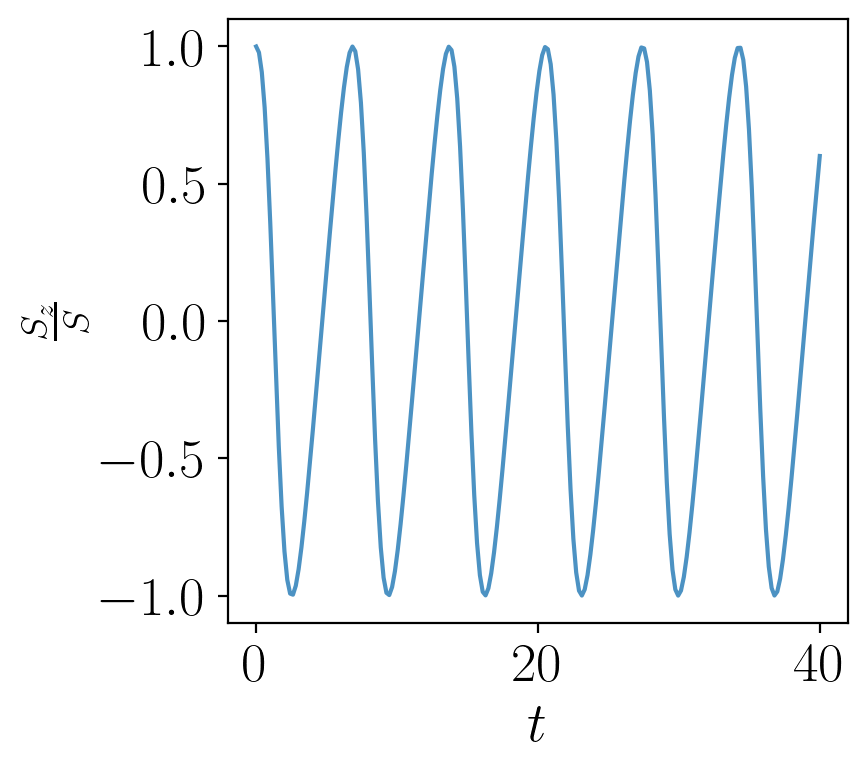

In [37]:
plot_data(t, y, r'$t$', r'$\frac{S_z}{S}$', r'Mean of $S_z$ Normalised', data, savedir = None)

## Solving the Equations

In [75]:
def eval_expr(delta, args):
    delta = delta
    f_list = list()
    for key in delta.keys():
        f = sym.lambdify([(w0,k,m_x,m_y,m_z,n_xx,n_xy,n_xz,n_yy,n_yz,n_zz)], delta[key])
        f_list.append(f(args))
    return f_list

In [76]:
def eval_expr_var(delta, args):
    delta = delta
    f_list = list()
    for key in delta.keys():
        f = sym.lambdify([(w0,k,m_x,m_y,m_z,ch_xx,ch_xy,ch_xz,ch_yy,ch_yz,ch_zz)], delta[key])
        f_list.append(f(args))
    return f_list

In [77]:
def solve_variance(t, initial_conditions, k, w0):
    #m_y, m_z, n_yy, n_yz, n_zz  = initial_conditions
    args = (w0,k,*initial_conditions)
    return eval_expr_var(delta, args)

In [78]:
sol = solve_ivp(solve_variance, [0, 200], [0,0,1,0,0,0,0,0,0.01], args=(0.2, 1), dense_output=True, method='BDF', max_step=0.01)
t = np.linspace(0, 200, 200)
z = sol.sol(t)
y = z.T[:,-1]
data = np.concatenate([t.reshape(1,len(t)),z])

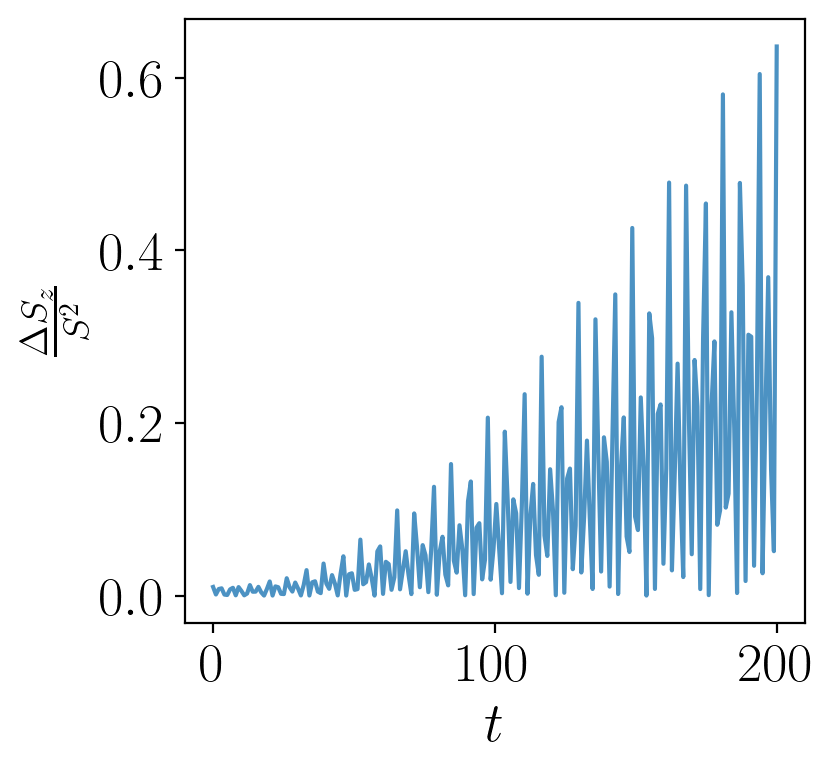

In [79]:
plot_data(t, y, r'$t$', r'$\frac{\Delta S_z}{S^2}$', r'Variance of $S_z$ Normalised', data, savedir = 'Second_order_inf_N')